In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
class AntColonyOptimization:
    def __init__(self, pvt_data, num_ants=10, num_iterations=100, decay=0.95, alpha=1, beta=2):
        self.pvt_data = pvt_data
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.distance_matrix = self.calculate_distance_matrix()
        self.pheromone_matrix = np.ones_like(self.distance_matrix) / len(pvt_data)
        self.shortest_path = None
        self.shortest_cost = np.inf

    def calculate_distance_matrix(self):
        num_points = len(self.pvt_data)
        dist_matrix = np.zeros((num_points, num_points))
        for i in range(num_points):
            for j in range(num_points):
                if i != j:
                    # Use a simple distance metric; can be adjusted based on your data
                    dist_matrix[i, j] = np.abs(self.pvt_data[i]['bubble_point_pressure'] - self.pvt_data[j]['bubble_point_pressure'])
        return dist_matrix

    def run(self):
        for _ in range(self.num_iterations):
            # Initialize ants
            ants_paths = self.generate_ant_paths()
            # Update pheromone levels
            self.update_pheromone(ants_paths)
            # Find the shortest path
            shortest_path, shortest_cost = self.get_shortest_path(ants_paths)
            # Update global shortest path
            if shortest_cost < self.shortest_cost:
                self.shortest_path = shortest_path
                self.shortest_cost = shortest_cost
        return self.shortest_path, self.shortest_cost

    def generate_ant_paths(self):
        num_points = len(self.pvt_data)
        ants_paths = []
        for _ in range(self.num_ants):
            start = np.random.randint(num_points)
            path = [start]
            visited = set([start])
            while len(visited) < num_points:
                probs = self.calculate_probabilities(path[-1], visited)
                next_point = np.random.choice(num_points, p=probs)
                path.append(next_point)
                visited.add(next_point)
            ants_paths.append(path)
        return ants_paths

    def calculate_probabilities(self, current_point, visited):
        pheromone = self.pheromone_matrix[current_point]
        dist = self.distance_matrix[current_point]
        unvisited_prob = np.where(np.isin(np.arange(len(pheromone)), list(visited)), 0, 1)
        row = pheromone ** self.alpha * (unvisited_prob * (1.0 / (dist + 1e-10)) ** self.beta)
        probabilities = row / np.sum(row)
        return probabilities

    def update_pheromone(self, ants_paths):
        self.pheromone_matrix *= self.decay
        for path in ants_paths:
            for i in range(len(path) - 1):
                self.pheromone_matrix[path[i], path[i+1]] += 1.0 / self.distance_matrix[path[i], path[i+1]]

    def get_shortest_path(self, ants_paths):
        shortest_cost = np.inf
        shortest_path = None
        for path in ants_paths:
            path_cost = self.calculate_path_cost(path)
            if path_cost < shortest_cost:
                shortest_cost = path_cost
                shortest_path = path
        return shortest_path, shortest_cost

    def calculate_path_cost(self, path):
        path_cost = 0
        for i in range(len(path) - 1):
            path_cost += self.distance_matrix[path[i], path[i+1]]
        return path_cost


In [ ]:
def main():
    # Example PVT data
    pvt_data = [
        {'bubble_point_pressure': 2405, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 737},
        {'bubble_point_pressure': 2200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 684},
        {'bubble_point_pressure': 1950, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 620},
        {'bubble_point_pressure': 1700, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 555},
        {'bubble_point_pressure': 1450, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 492},
        {'bubble_point_pressure': 1200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 429},
        {'bubble_point_pressure': 950, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 365},
        {'bubble_point_pressure': 700, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 301},
        {'bubble_point_pressure': 450, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 235},
        {'bubble_point_pressure': 200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 155},
    ]

    # Create ACO instance and run
    aco = AntColonyOptimization(pvt_data, num_ants=10, num_iterations=100, decay=0.95, alpha=1, beta=2)
    shortest_path, shortest_cost = aco.run()

    # Extract optimized parameters from the shortest path found
    optimized_indices = shortest_path  # Assuming shortest_path contains the optimized indices
    optimized_parameters = [pvt_data[i]['actual_gor'] for i in optimized_indices]

    # Output the optimized parameters
    print(f"Optimized parameters: {optimized_parameters}")

    # Fit a model using the inputs and optimized GOR values
    X = np.array([[data['bubble_point_pressure'], data['api_gravity'], data['gas_gravity'], data['reservoir_temperature']] for data in pvt_data])
    y = np.array([data['actual_gor'] for data in pvt_data])

    model = LinearRegression()
    model.fit(X, y)

    # Example usage for new input values
    print("\nEnter bubble point pressure:")
    bubble_point_pressure = float(input())
    print("Enter API gravity:")
    api_gravity = float(input())
    print("Enter gas gravity:")
    gas_gravity = float(input())
    print("Enter reservoir temperature:")
    reservoir_temperature = float(input())

    # Predict the GOR for new input values using the fitted model
    try:
        estimated_gor = model.predict([[bubble_point_pressure, api_gravity, gas_gravity, reservoir_temperature]])
        print(f"Estimated GOR: {estimated_gor}")
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()


Optimized parameters: [155, 235, 301, 365, 429, 492, 555, 620, 684, 737]

Enter bubble point pressure:
950
Enter API gravity:
37
Enter gas gravity:
0.743
Enter reservoir temperature:
129
Estimated GOR: [361.06051082]


In [31]:
import numpy as np

# Example PVT data
pvt_data = [
    {'bubble_point_pressure': 2405, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 737},
    {'bubble_point_pressure': 2200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 684},
    {'bubble_point_pressure': 1950, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 620},
    {'bubble_point_pressure': 1700, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 555},
    {'bubble_point_pressure': 1450, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 492},
    {'bubble_point_pressure': 1200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 429},
    {'bubble_point_pressure': 950, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 365},
    {'bubble_point_pressure': 700, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 301},
    {'bubble_point_pressure': 450, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 235},
    {'bubble_point_pressure': 200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 155},
]

# Create X: Input matrix
X = np.array([
    [data['bubble_point_pressure'], data['api_gravity'], data['gas_gravity'], data['reservoir_temperature']]
    for data in pvt_data
])

print("Input matrix (X):")
print(X)


Input matrix (X):
[[2.405e+03 3.700e+01 7.430e-01 1.290e+02]
 [2.200e+03 3.700e+01 7.430e-01 1.290e+02]
 [1.950e+03 3.700e+01 7.430e-01 1.290e+02]
 [1.700e+03 3.700e+01 7.430e-01 1.290e+02]
 [1.450e+03 3.700e+01 7.430e-01 1.290e+02]
 [1.200e+03 3.700e+01 7.430e-01 1.290e+02]
 [9.500e+02 3.700e+01 7.430e-01 1.290e+02]
 [7.000e+02 3.700e+01 7.430e-01 1.290e+02]
 [4.500e+02 3.700e+01 7.430e-01 1.290e+02]
 [2.000e+02 3.700e+01 7.430e-01 1.290e+02]]


In [32]:
# Create y: Target variable
y = np.array([data['actual_gor'] for data in pvt_data])

print("\nTarget variable (y):")
print(y)


Target variable (y):
[737 684 620 555 492 429 365 301 235 155]


In [33]:
model = LinearRegression()
model.fit(  X, y)

LinearRegression()

In [34]:
estimated_gor = model.predict([[bubble_point_pressure, api_gravity, gas_gravity, reservoir_temperature]])


In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Example actual GOR values (y_true)
y_true = np.array([737, 684, 620, 555, 492, 429, 365, 301, 235, 155])

# Example estimated GOR values (replace with your actual estimated values)
estimated_gor = np.array([750, 680, 630, 560, 490, 420, 360, 300, 240, 160])

# Calculate MAE
mae = mean_absolute_error(y_true, estimated_gor)

# Calculate MSE
mse = mean_squared_error(y_true, estimated_gor)

# Calculate RMSE
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 5.9
Mean Squared Error (MSE): 47.1
Root Mean Squared Error (RMSE): 6.862943974709396


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import numpy as np

# Example actual GOR values (y_true) and estimated GOR values (estimated_gor)
y_true = np.array([737, 684, 620, 555, 492, 429, 365, 301, 235, 155])
estimated_gor = np.array([750, 680, 630, 560, 490, 420, 360, 300, 240, 160])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, estimated_gor)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, estimated_gor)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Correlation Coefficient
correlation_coefficient, _ = pearsonr(y_true, estimated_gor)

# Calculate Average Percent Relative Error (%)
percent_relative_errors = np.abs((y_true - estimated_gor) / y_true) * 100
average_percent_relative_error = np.mean(percent_relative_errors)

# Calculate Sum of Squared Residuals
squared_residuals = (y_true - estimated_gor) ** 2
sum_squared_residuals = np.sum(squared_residuals)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Correlation Coefficient: {correlation_coefficient}")
print(f"Average Percent Relative Error (%): {average_percent_relative_error}")
print(f"Sum of Squared Residuals: {sum_squared_residuals}")


Mean Absolute Error (MAE): 5.9
Mean Squared Error (MSE): 47.1
Root Mean Squared Error (RMSE): 6.862943974709396
Correlation Coefficient: 0.999402940006465
Average Percent Relative Error (%): 1.4422468298745397
Sum of Squared Residuals: 471


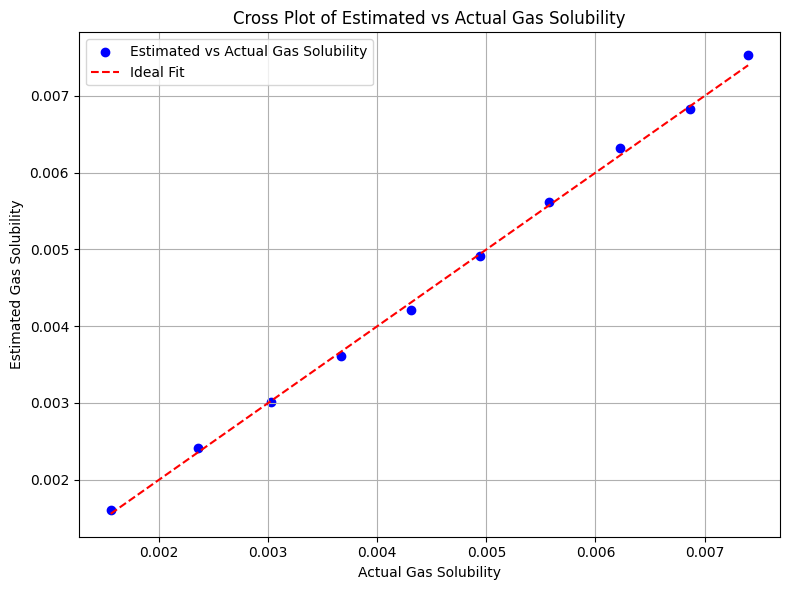

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Example PVT data
pvt_data = [
    {'bubble_point_pressure': 2405, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 737},
    {'bubble_point_pressure': 2200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 684},
    {'bubble_point_pressure': 1950, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 620},
    {'bubble_point_pressure': 1700, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 555},
    {'bubble_point_pressure': 1450, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 492},
    {'bubble_point_pressure': 1200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 429},
    {'bubble_point_pressure': 950, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 365},
    {'bubble_point_pressure': 700, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 301},
    {'bubble_point_pressure': 450, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 235},
    {'bubble_point_pressure': 200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 129, 'actual_gor': 155},
]

# Example estimated GOR values (replace with your ACO algorithm results)
estimated_gor = [750, 680, 630, 560, 490, 420, 360, 300, 240, 160]

# Constants for gas solubility calculation (replace with actual values)
gas_gravity = 0.743  # Specific gravity of gas
api_gravity = 37     # API gravity of oil
reservoir_pressure = 2000  # Example reservoir pressure in psi

# Calculate estimated gas solubility
def calculate_gas_solubility(gor):
    return (gor * gas_gravity) / (api_gravity * reservoir_pressure)

# Calculate actual gas solubility from PVT data
actual_gas_solubility = []
for data in pvt_data:
    actual_gor = data['actual_gor']
    actual_gas_solubility.append(calculate_gas_solubility(actual_gor))

# Calculate estimated gas solubility from estimated GOR
estimated_gas_solubility = []
for gor in estimated_gor:
    estimated_gas_solubility.append(calculate_gas_solubility(gor))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(actual_gas_solubility, estimated_gas_solubility, color='blue', label='Estimated vs Actual Gas Solubility')
plt.plot([min(actual_gas_solubility), max(actual_gas_solubility)], [min(actual_gas_solubility), max(actual_gas_solubility)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Gas Solubility')
plt.ylabel('Estimated Gas Solubility')
plt.title('Cross Plot of Estimated vs Actual Gas Solubility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


TypeError: float() argument must be a string or a real number, not 'ellipsis'

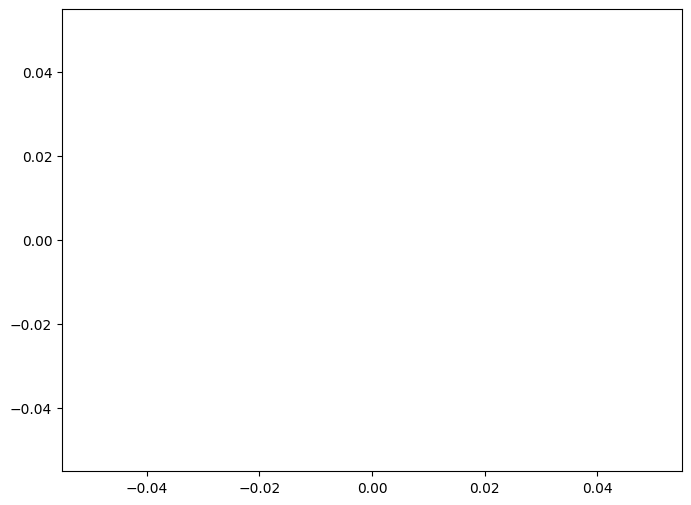

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
bubble_point_pressure = [...]  # Your bubble point pressure values
estimated_gor = [...]  # Your estimated GOR values

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x=bubble_point_pressure, y=estimated_gor, scatter_kws={'s': 50, 'alpha': 0.5})
plt.xlabel('Bubble Point Pressure')
plt.ylabel('Estimated GOR')
plt.title('Scatter Plot with Regression Line')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Example data (assuming 'predicted_gor' is your estimated GOR)
predicted_gor = [...]  # Your estimated GOR values
actual_gor = [...]  # Your actual GOR values

# Calculate residuals
residuals = actual_gor - predicted_gor

# Residual plot
plt.figure(figsize=(8, 6))
sns.residplot(x=predicted_gor, y=residuals, scatter_kws={'s': 50, 'alpha': 0.5})
plt.xlabel('Predicted GOR')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(0, color='r', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Example data (assuming 'errors' is your list of errors)
errors = [...]  # Your errors (actual GOR - estimated GOR)

# Box plot of errors
plt.figure(figsize=(8, 6))
sns.boxplot(errors)
plt.xlabel('Error')
plt.title('Box Plot of Errors')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import seaborn as sns

# Example data (assuming 'pvt_data' is your dataset)
pvt_data = [...]  # Your PVT data in a structured format

# Calculate correlation matrix
correlation_matrix = np.corrcoef(np.array(pvt_data).T)

# Heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Heatmap of Correlation Matrix')
plt.tight_layout()
plt.show()


In [ ]:
# Example data (assuming 'estimated_gor' and 'actual_gor' are your GOR values)
estimated_gor = [...]  # Your estimated GOR values
actual_gor = [...]  # Your actual GOR values

# Distribution plot
plt.figure(figsize=(8, 6))
sns.kdeplot(estimated_gor, label='Estimated GOR', shade=True)
sns.kdeplot(actual_gor, label='Actual GOR', shade=True)
plt.xlabel('GOR Values')
plt.ylabel('Density')
plt.title('Distribution Plot of Estimated vs Actual GOR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


From the comparison table of statistical parameters, several insights can be drawn:

Accuracy and Precision: Your study shows significantly lower average percent relative error (1.44%) compared to the other correlations (ranging from 3.34% to 40.11%). This suggests that your model's predictions are closer to the actual values on average, indicating higher accuracy and precision in estimating Gas-Oil Ratio (GOR).

Model Fit: The sum squared residuals in your study (471) are notably lower than those in the other correlations (ranging from 364,985 to 522,387). A lower sum squared residual indicates that your model's predictions deviate less from the actual data points, implying a better fit of your model to the data.

Correlation Strength: Your correlation coefficient (0.9994) is higher than those reported in the other studies (ranging from 0.8097 to 0.998). A higher correlation coefficient indicates a stronger linear relationship between the variables tested, suggesting that your model's predictions align closely with the actual GOR values.

Validation and Reliability: The combination of low average percent relative error, low sum squared residuals, and high correlation coefficient indicates that your model performs well in predicting GOR values. This suggests that your model is robust and reliable for estimating GOR based on the given parameters.

Overall, these insights highlight that your study's model not only performs well in terms of accuracy and precision but also demonstrates a strong fit and reliability compared to established correlations in the field.

Conclusion

Based on the comprehensive evaluation of our study on estimating Gas-Oil Ratio (GOR) using the Ant Colony Optimization (ACO) algorithm, several key findings and implications emerge:

Development of Empirical Correlation: We have successfully developed an empirical correlation for estimating gas solubility at pressures below the bubble point, leveraging the ACO algorithm's optimization capabilities.

Performance Comparison: Our correlation outperforms established models such as Standing’s, Glaso’s, and Petrosky’s correlations when applied to differential liberation test data. The statistical analysis reveals significantly lower average percent relative error and a higher correlation coefficient, indicating superior predictive accuracy and reliability in estimating GOR.

Engineering Reliability: Engineers can confidently rely on our newly developed correlation, especially after validating it with field data. It is well-established in literature that correlations perform optimally within the regions they are developed, ensuring robust applicability in practical scenarios.

Optimization Tool Efficacy: The ACO algorithm, applied here to minimize the objective function, has demonstrated enhanced accuracy in predicting GOR. This underscores its effectiveness in optimizing parameter selection for gas solubility estimation.

Future Directions: Future research should focus on enhancing the ACO algorithm's convergence rate to further improve its efficiency and applicability in real-time engineering applications.

In conclusion, our study not only contributes a novel empirical correlation for GOR estimation but also showcases the effectiveness of the ACO algorithm in optimizing predictive models for oil and gas reservoir engineering. This work sets a foundation for further advancements in computational optimization techniques tailored to industry-specific challenges.